# Ferret data
First, we load the imaging data used in Macke et al. (2011). Its size is (npixels_x, npixels_y, conditions, trials).

In [1]:
%matplotlib inline
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(134)

data = scipy.io.loadmat('data/ferretdata.mat')
data = data['dat'] # data is stored in a dict
data.shape

(126, 252, 8, 100)

Reshape the data to (conditions, trials, npixels_x, npixels_y) and split the data into one part used as "ground truth" (95%) and one part used for inference (5%).

In [21]:
R = np.transpose(data[26:,:200,:,:], (2,3,0,1))

# take only a small part of the image (for performance reasons)
#R = R[:,:,38:58,106:136]

# downsample image
#R = R[:,:,::2,::2]

size = R.shape[2:]
n = size[0] * size[1]
N = R.shape[0] * R.shape[1]
R.shape

(8, 100, 100, 200)

## Plot responses
Visualize the responses for the small patch

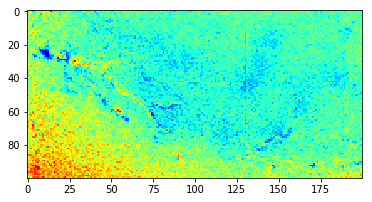

In [22]:
plt.imshow(R[0,np.random.randint(5),:,:], cmap='jet')
plt.show()

## Maximum likelihood solution
Compute the solution using vector averaging (for details see OPM.ipynb)

In [23]:
from opm import calculate_map, plot_opm, plot_amplitude_map
from opm.response import create_stimuli

In [24]:
angles = [i * np.pi / 4 for i in range(4)]*2

V = create_stimuli([1.], angles, 100)
d = V.shape[2]
V.shape

(8, 100, 3)

In [25]:
#m_gt = calculate_map(R_gt, create_stimuli([1.], angles, 95))
#m_gt = m_gt[0] + 1j * m_gt[1]

m_hat = calculate_map(R, V)

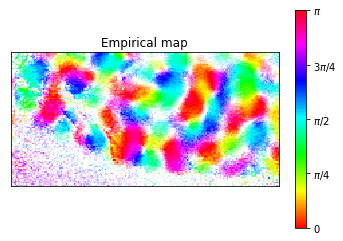

In [26]:
#plot_opm(m_gt, pinwheels=False, shade=True, rmax=80, title='Ground truth')
#plt.show()

plot_opm(m_hat[0] + 1j * m_hat[1], pinwheels=False, shade=True, rmax=80, title='Empirical map')
plt.show()

### Noise covariance
We examine the noise variances (i.e. the diagonal of the noise covariance matrix).

In [27]:
z = R.reshape(N, n) - V.reshape(N, d) @ m_hat.reshape(d, n)
cov = np.cov(z.T)

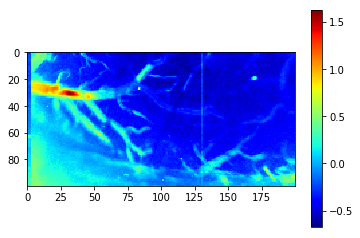

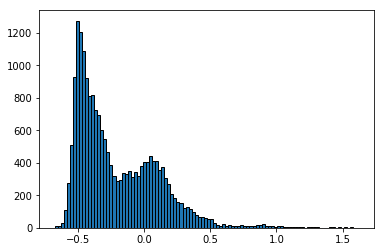

In [28]:
plt.imshow(np.log10(np.diag(cov)).reshape(*R.shape[2:]), cmap='jet')
plt.colorbar()
plt.show()

plt.hist(np.log10(np.diag(cov)), bins=100, edgecolor='black')
plt.show()

In [29]:
from opm.covariance import avg_neighbor_corr

nbcorr = avg_neighbor_corr(cov, size=size, radius=2)

In [30]:
nbcorr.shape

(100, 200)

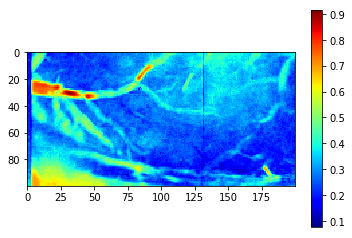

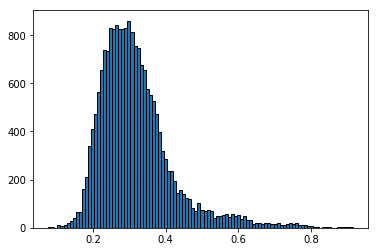

In [31]:
plt.imshow(nbcorr, cmap='jet')
plt.colorbar()
plt.show()

plt.hist(nbcorr.reshape(-1), bins=100, edgecolor='black')
plt.show()

## Gaussian Process method
Compute a smooth OPM using the GP method (see BayesianOPM.ipynb)

In [14]:
from opm.gp import GaussianProcessOPM

In [32]:
gp = GaussianProcessOPM(size=size, prior_method='icd', prior_rank=1600)

In [33]:
mu_post = gp.fit(stimuli=V, responses=R, noise='factoran', verbose=True, noise_kwargs={'iterations':3, 'q':4})

Estimating prior hyperparameters:
{'sigma': 6.125528771169098, 'alpha': 4.3730784921054}
*** Fitting prior ***
Calculating the prior from scratch..


KeyboardInterrupt: 

In [13]:
gp.save(fname='pkl/ferret_{}x{}.pkl'.format(*size))

In [9]:
gp = GaussianProcessOPM.load(fname='pkl/ferret_{}x{}.pkl'.format(*size))

In [11]:
#mu = m.reshape(3, size)
result = gp.mu_post[0] + 1j * gp.mu_post[1]

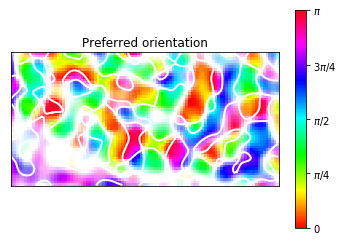

In [12]:
f, ax = plot_opm(result, shade=True, rmax=80)
plt.show()